In [2]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import sklearn as sk
import os
import tensorflow as tf
import keras
import seaborn as sns
import h5py as h5py
from time import time
import sys
import matplotlib.pyplot as plt

MDN_MODULE_PATH = "/Users/chriswang/Downloads/gym-sepsis/keras-mdn-layer"
sys.path.append(MDN_MODULE_PATH)

import mdn

# %load_ext autoreload
# %autoreload 2

Using TensorFlow backend.



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:

data = np.load("../data/embedded_data.npz")


In [4]:
# used for gym environment
np.savez("sepsis_starting_states.npz", sepsis_starting_states = data['x_test'])

In [5]:
data.files

['x_train_e',
 'y_train_e',
 'x_test_e',
 'y_test_e',
 'x_train',
 'x_test',
 'y_train',
 'y_test']

In [6]:
data['x_train_e'].shape

(153582, 31)

In [7]:
max_episode = 10

def get_padded_matrix(x_, y_):
    episode_matrix = np.zeros(shape=[x_.shape[0], max_episode, x_.shape[1]])
    episode = []
    for idx in range(len(x_)):
        # within on episode
        episode.append(x_[idx])
        for event_idx in range(min(len(episode), max_episode)):
            episode_matrix[idx][-(event_idx%max_episode)-1] = episode[-event_idx - 1]
        if np.equal(x_[idx][:-1],y_[idx]).all():
            # episode changed
            episode = []
    return episode_matrix

In [8]:
train_matrix = get_padded_matrix( data['x_train_e'],  data['y_train_e'])

In [9]:
train_matrix.shape

(153582, 10, 31)

In [10]:
test_matrix = get_padded_matrix( data['x_test_e'],  data['y_test_e'])

In [11]:
mixtures =46
output_dim = train_matrix.shape[2]-1
model = keras.Sequential([
    keras.layers.LSTM(50, input_shape=(train_matrix.shape[1], train_matrix.shape[2])),
    keras.layers.Dense(128, activation='relu')
])
model.add(mdn.MDN(output_dim, mixtures))

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50)                16400     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
mdn_1 (MDN)                  (None, 2806)              361974    
Total params: 384,902
Trainable params: 384,902
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss=mdn.get_mixture_loss_func(output_dim, mixtures), optimizer=keras.optimizers.Adam())

In [13]:
tensorboard = keras.callbacks.TensorBoard(log_dir="logs/lstm_no_embed_bayesian{}".format(time()))
cp_callback = keras.callbacks.ModelCheckpoint("sepsis_states_bayesian_ae_46.model",
                                                 verbose=1, monitor='val_loss', save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

model.fit(train_matrix, data['y_train_e'], validation_data=(test_matrix, data['y_test_e']), epochs=10, callbacks=[tensorboard, cp_callback, early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 153582 samples, validate on 39232 samples
Epoch 1/10
153582/153582 [==============================] - 212s 1ms/step - loss: 10.1067 - val_loss: -1.1340

Epoch 00001: val_loss improved from inf to -1.13400, saving model to sepsis_states_bayesian_ae_46.model
Epoch 2/10
153582/153582 [==============================] - 221s 1ms/step - loss: -3.7326 - val_loss: -9.0306

Epoch 00002: val_loss improved from -1.13400 to -9.03057, saving model to sepsis_states_bayesian_ae_46.model
Epoch 3/10
153582/153582 [==============================] - 234s 2ms/step - loss: -7.1352 - val_loss: -9.1035

Epoch 00003: val_loss improved from -9.03057 to -9.10348, saving model to sepsis_states_bayesian_ae_46.model
Epoch 4/10
153582/153582 [==============================] - 246s 2ms/step - loss: -11.2565 - val_loss: -14.8371

Epoch 00004: val_loss improved from -9.10348 to -14.83706, saving model to sepsis_states_bayesian_ae_46.model
Epoch 5/10
153582/15358

In [14]:
vae_model = tf.keras.models.load_model("ae.model", compile=False)

In [15]:
model = keras.models.load_model("sepsis_states_bayesian_ae_46.model", compile=False, custom_objects={'MDN': mdn.MDN(output_dim, mixtures) })

In [16]:
#print(model.layers)
def get_decoder(vae_model):
    input_layer = tf.keras.layers.Input(shape=(30,))
    decoder_layer1 = vae_model.layers[3]
    decoder_layer2 = vae_model.layers[4]
    decoder_layer3 = vae_model.layers[5]
    decoder = tf.keras.Model(input_layer, decoder_layer3(decoder_layer2(decoder_layer1(input_layer))))
    return decoder
#model_vae = tf.keras.models.load_model("vae_noklloss.model")
decoder = get_decoder(vae_model)

In [17]:
test_predicted_dists = model.predict(test_matrix)

In [18]:
train_predicted_dists = model.predict(train_matrix)

In [19]:
columns = ['ALBUMIN', 'ANION GAP', 'BANDS', 'BICARBONATE',
       'BILIRUBIN', 'BUN', 'CHLORIDE', 'CREATININE', 'DiasBP', 'Glucose',
       'GLUCOSE', 'HeartRate', 'HEMATOCRIT', 'HEMOGLOBIN', 'INR', 'LACTATE',
       'MeanBP', 'PaCO2', 'PLATELET', 'POTASSIUM', 'PT', 'PTT', 'RespRate',
       'SODIUM', 'SpO2', 'SysBP', 'TempC', 'WBC', 'age', 'is_male',
       'race_white', 'race_black', 'race_hispanic', 'race_other', 'height',
       'weight', 'vent', 'sofa', 'lods', 'sirs', 'qsofa', 'qsofa_sysbp_score',
       'qsofa_gcs_score', 'qsofa_resprate_score', 'elixhauser_hospital',
       'blood_culture_positive']

In [20]:
test_predicted_vae = np.apply_along_axis(mdn.sample_from_output, 1, test_predicted_dists, output_dim, mixtures, temp=1.0)


In [21]:
test_predicted_vae = decoder.predict(test_predicted_vae.reshape((test_predicted_vae.shape[0], test_predicted_vae.shape[2])))

In [22]:
%store -r test_predicted

In [23]:
test_predicted[0:11,columns.index('HeartRate')]

array([-0.77429004, -0.26247878, -1.67511792, -0.69404618, -0.7044804 ,
       -1.23988449, -0.21374062,  0.09627981, -1.91943202, -1.20173696,
       -1.82604681])

In [24]:
sns.set(style="white")

def plot(column, mode="test", prediction=test_predicted, predictionvae=test_predicted_vae):
    from matplotlib.pyplot import figure
    figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(data['y_'+mode][6:24,columns.index(column)], label="truth", scaley=False)
    plt.plot(prediction[6:24,columns.index(column)], label="predicted", scaley=False)
    plt.plot(predictionvae[6:24,columns.index(column)], label="predicted", scaley=False)
    plt.ylim(-2, 2)
    plt.legend(["Real Value", "Predicted (With MDN)", "Predicted (With VAE and MDN)"])
    plt.title(column + " " + mode)
    plt.show()

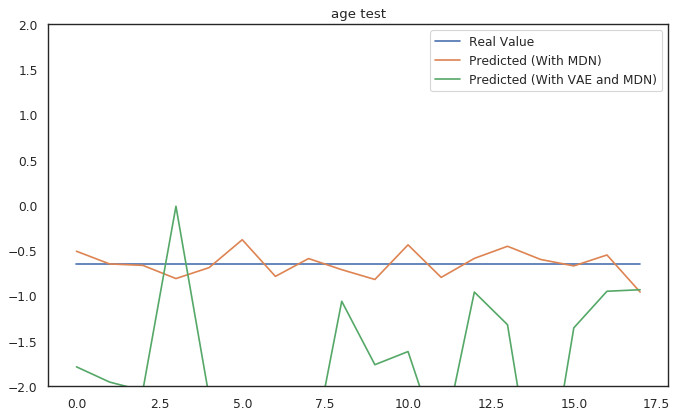

In [25]:
plot("age", "test", test_predicted, test_predicted_vae)

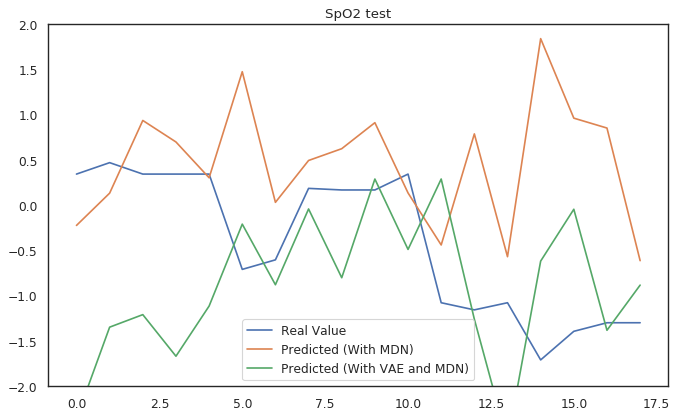

In [26]:
plot("SpO2", "test", test_predicted)

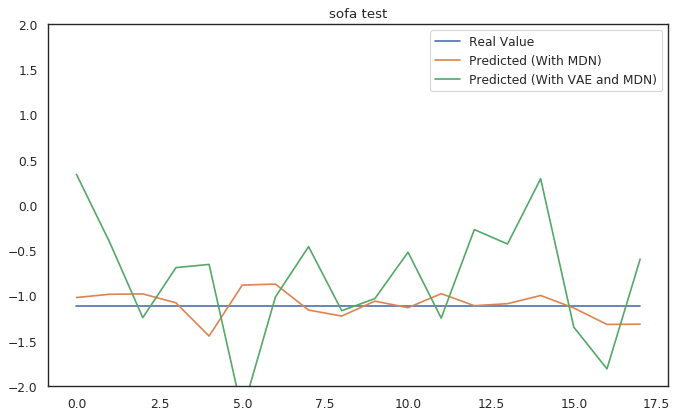

In [27]:
plot("sofa")

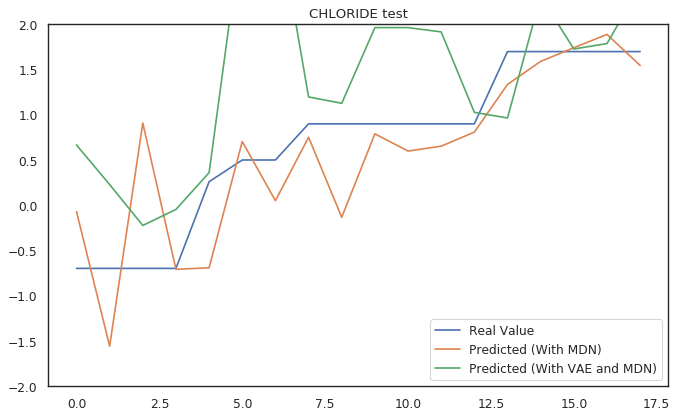

In [28]:
plot('CHLORIDE')

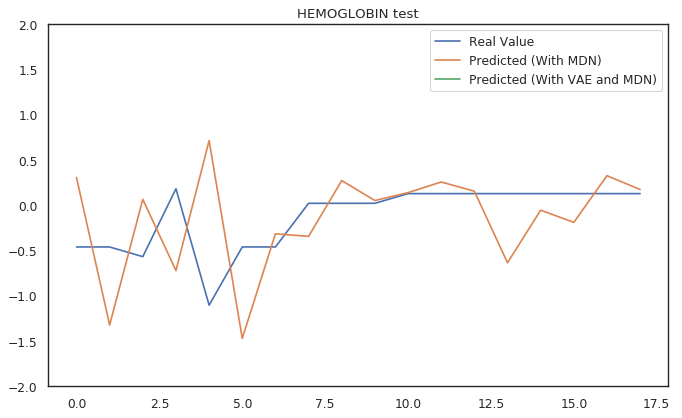

In [29]:
plot("HEMOGLOBIN")

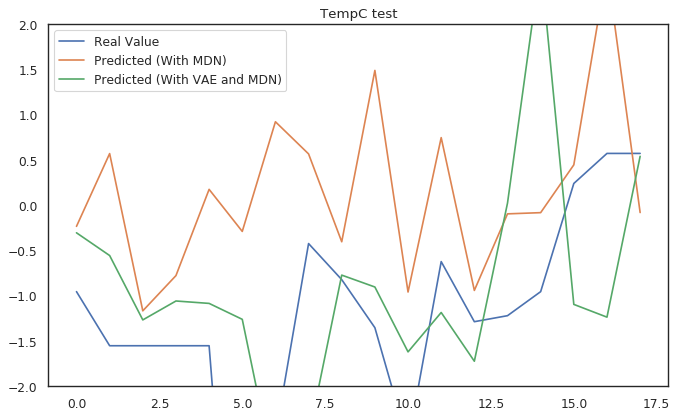

In [34]:
plot("TempC")

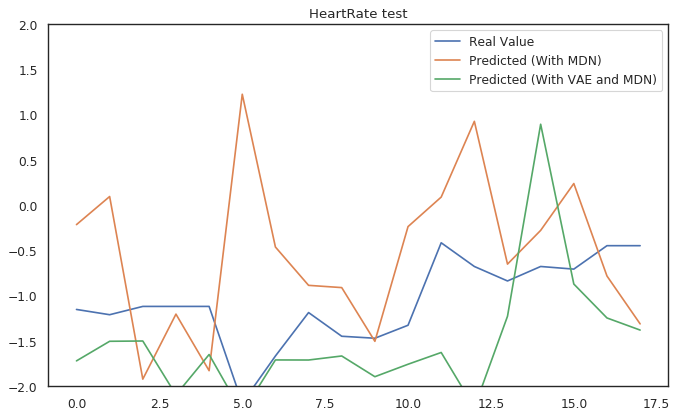

In [31]:
plot("HeartRate")

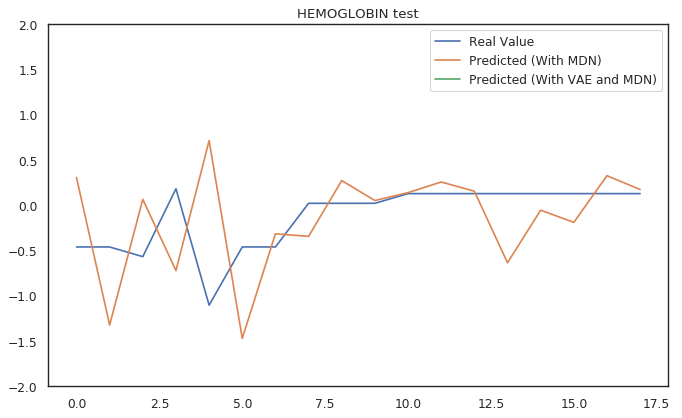

In [32]:
plot("HEMOGLOBIN")

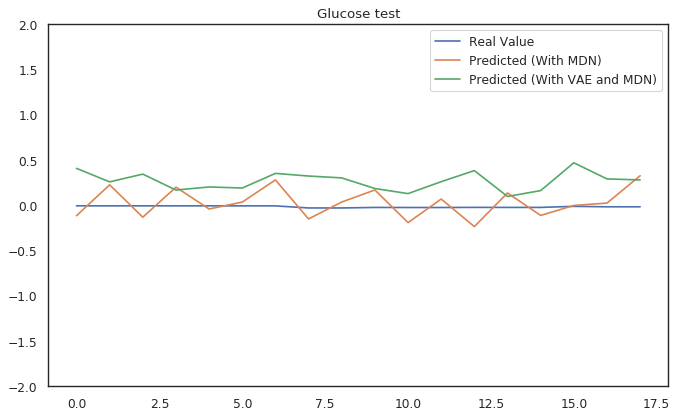

In [33]:
plot("Glucose")